## Overview
Quickly demonstrates the NFourSID package.
Familiarity with subspace-identification, Kalman filtering and state-space models are assumed.

In this notebook, the following steps will be illustrated:
* Define a state-space model,
* Create a training-set and simulate measurement noise,
* Perform subspace identification and determine the order of the system which will be identified,
* Obtain a fitted state-space model,
* Use a Kalman filter to obtain predictions.

First, let's define the parameters of the state-space model and do some housekeeping.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from nfoursid.kalman import Kalman
from nfoursid.nfoursid import NFourSID
from nfoursid.state_space import StateSpace

pd.set_option('display.max_columns', None)
np.random.seed(0)  # reproducable results

NUM_TRAINING_DATAPOINTS = 1000  # create a training-set by simulating a state-space model with this many datapoints
NUM_TEST_DATAPOINTS = 20  # same for the test-set
INPUT_DIM = 1
OUTPUT_DIM = 1
INTERNAL_STATE_DIM = 2  # actual order of the state-space model in the training- and test-set
NOISE_AMPLITUDE = .1  # add noise to the training- and test-set
FIGSIZE = 8

# define system matrices for the state-space model of the training- and test-set
'''
A = np.array([
    [1,  .01,    0,   0],
    [0,    1,  .01,   0],
    [0,    0,    1, .02],
    [0, -.01,    0,   1],
]) / 1.01
B = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
]
) / 3
C = np.array([
    [1, 0, 1,  1],
    [0, 0, 1, -1],
])
D = np.array([
    [0, 0, 0],
    [0, 0, 0]
]) / 10
'''


A = np.array([[ 0.999505  ,  0.00984985],
       [-0.09849847,  0.96995546]])

B = np.array([[0.],
       [0.]])

C = np.array([[1., 0.]])
D = np.array([[0.]])




Create a training-set by adding noise to a state-space model:

In [2]:
state_space = StateSpace(A, B, C, D)
for _ in range(NUM_TRAINING_DATAPOINTS):
    input_state = np.random.standard_normal((INPUT_DIM, 1))
    noise = np.random.standard_normal((OUTPUT_DIM, 1)) * NOISE_AMPLITUDE

    state_space.step(input_state, noise)

The state-space model has 3 inputs, a 4-dimensional internal state vector and 2 outputs. 
Plotting the dataset can be done using `StateSpace.plot_input_output`.

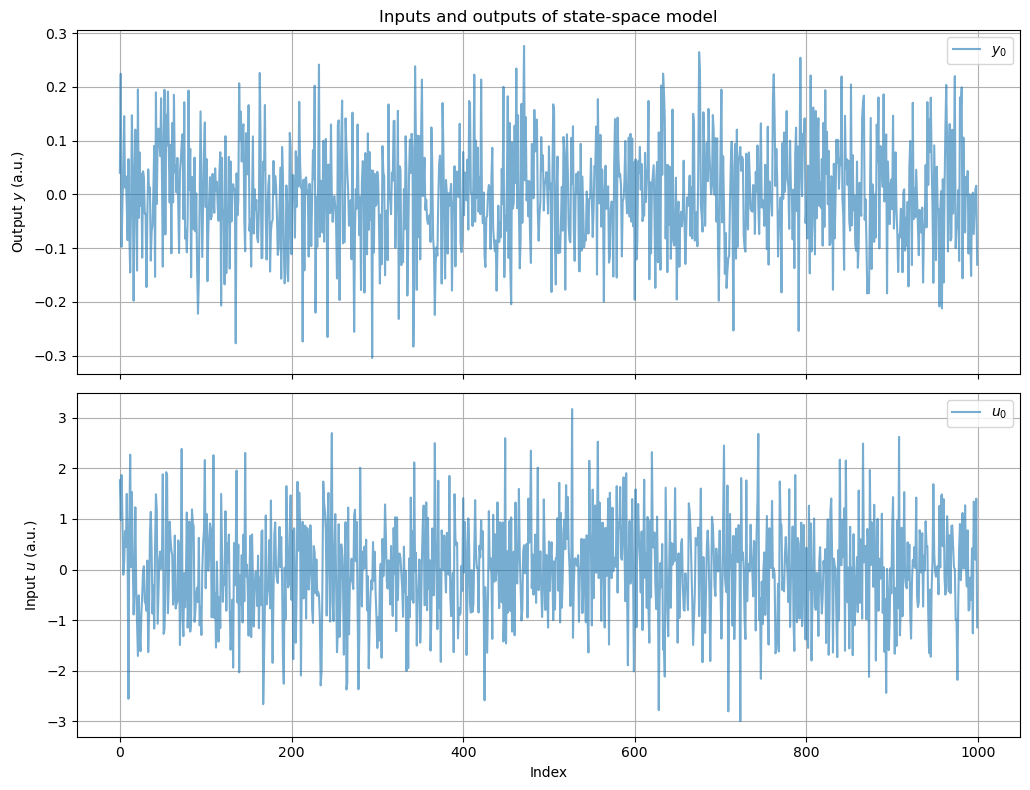

In [3]:
figsize = (1.3 * FIGSIZE, FIGSIZE)
fig = plt.figure(figsize=figsize)
state_space.plot_input_output(fig)  # the state-space model can plot its inputs and outputs
fig.tight_layout()

At the moment, suppose that we don't know the order of the internal state vector.
Let's perform subspace identification.

In [4]:
nfoursid = NFourSID(
    state_space.to_dataframe(),  # the state-space model can summarize inputs and outputs as a dataframe
    output_columns=state_space.y_column_names,
    input_columns=state_space.u_column_names,
    num_block_rows=10
)
nfoursid.subspace_identification()

Plotting the eigenvalues of the estimated observability matrix is done with `NFourSID.plot_eigenvalues`.

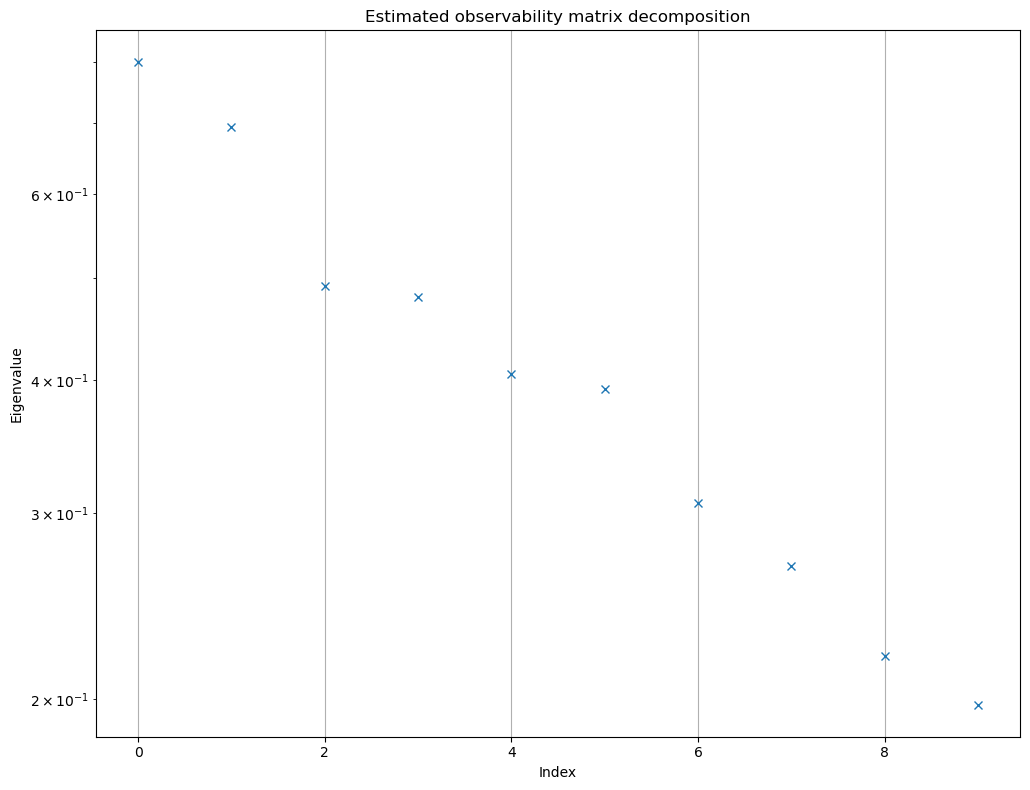

In [5]:
fig, ax = plt.subplots(figsize=figsize)
nfoursid.plot_eigenvalues(ax)
fig.tight_layout()

This gives us a signal that the order of the state-space model is 4.
Let's identify the system matrices.

In [6]:
ORDER_OF_MODEL_TO_FIT = 2
state_space_identified, covariance_matrix = nfoursid.system_identification(
    rank=ORDER_OF_MODEL_TO_FIT
)

Generate a test-set and use Kalman filtering to evaluate prediction performance:

In [7]:
kalman = Kalman(state_space_identified, covariance_matrix)
state_space = StateSpace(A, B, C, D)  # new data for the test-set
for _ in range(NUM_TEST_DATAPOINTS):  # make a test-set
    input_state = np.random.standard_normal((INPUT_DIM, 1))
    noise = np.random.standard_normal((OUTPUT_DIM, 1)) * NOISE_AMPLITUDE

    y = state_space.step(input_state, noise)  # generate test-set
    kalman.step(y, input_state)  # the Kalman filter sees the output and input, but not the actual internal state

Plot the filtered state of the Kalman filter using `Kalman.plot_filtered`.
The top graph shows the output of the Kalman filter against the filtered states.
Expected standard deviation is plotted as error bars.

The bottom graph zooms in on the filtering error.
In this plot, expected standard deviation is plotted as dotted lines.

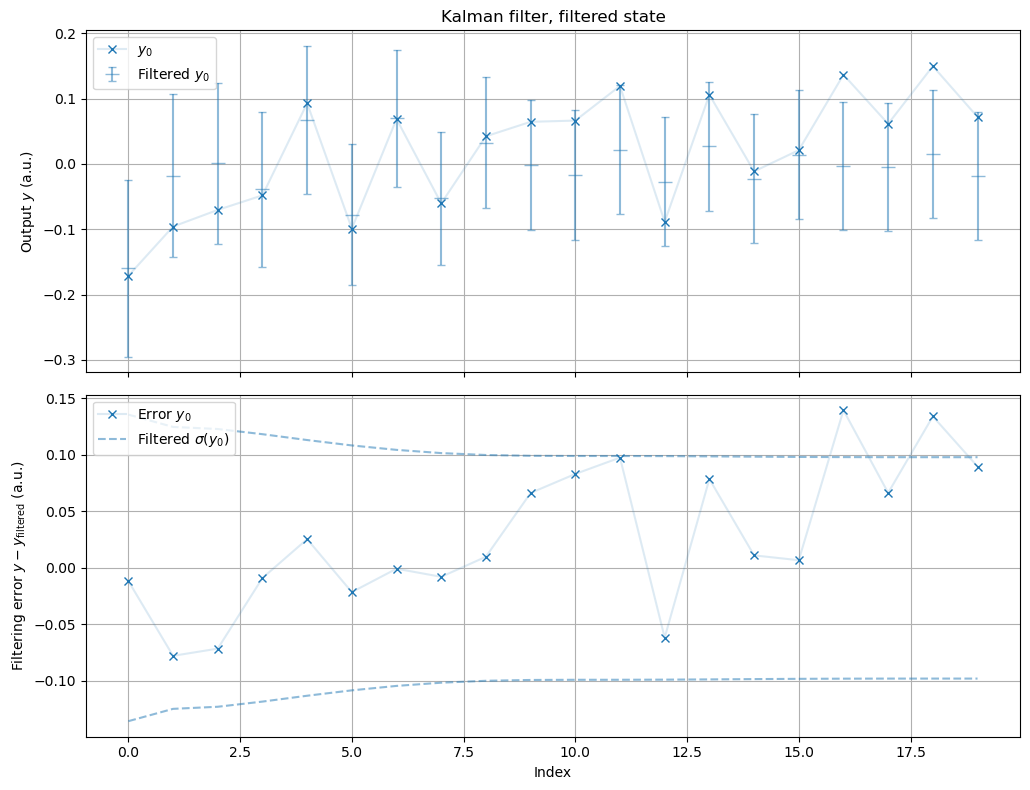

In [8]:
fig = plt.figure(figsize=figsize)
kalman.plot_filtered(fig)
fig.tight_layout()

The Kalman filter also provides an prediction of the next internal state.
Based on the predicted internal state and the fitted model, it is possible to estimate the output of the next timestep.
It is necessary to correct the output prediction with the known input of the next timestep using the estimated system matrix `Kalman.state_space.d`.
This is not a limitation, because the inputs and estimated system matrices are known to the experimenter.

The predicted outputs can be plotted using `Kalman.plot_predicted`, like the previous plot of the filtered states.
The one-step ahead predicted output, assuming no further inputs, is shown as a star with expected standard deviation as error bars.

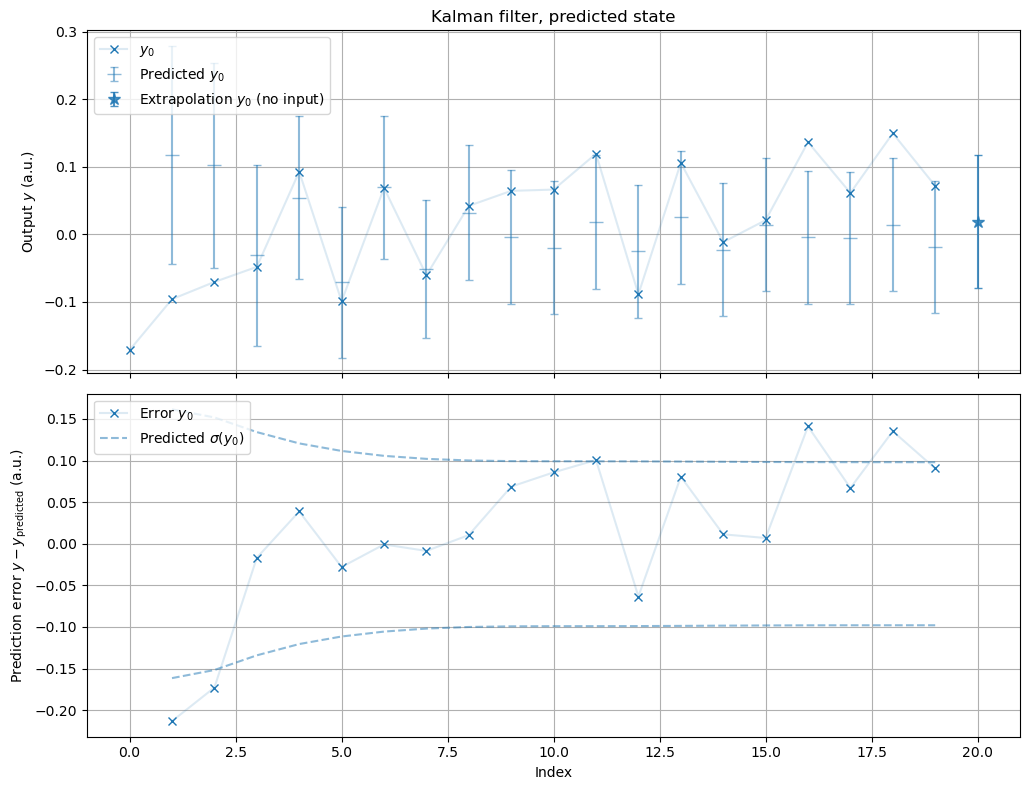

In [9]:
fig = plt.figure(figsize=figsize)
kalman.plot_predicted(fig)
fig.tight_layout()

We can access the output data of the Kalman filter using `Kalman.to_dataframe()`.
This returns a dataframe for all output columns containing
* The actual output, which was given to the Kalman filter using `Kalman.step`,
* The filtered output state,
* The next predicted state, assuming no further inputs,
* The next predicted state, adjusted ex-post with the next input.

In [10]:
kalman.to_dataframe()

$y_0$                                                         \
      actual  filtered                    next predicted (no input)   
      output    output standard deviation                    output   
0  -0.171197 -0.159550           0.135721                  0.117509   
1  -0.095837 -0.017973           0.124814                  0.102354   
2  -0.070386  0.001099           0.122954                 -0.032603   
3  -0.048085 -0.039118           0.118383                  0.055417   
4   0.092915  0.067472           0.113200                 -0.070284   
5  -0.098982 -0.077532           0.108427                  0.070956   
6   0.068890  0.069613           0.104494                 -0.051215   
7  -0.060362 -0.052463           0.101649                  0.033264   
8   0.042282  0.032426           0.099961                 -0.010092   
9   0.064445 -0.001888           0.099237                 -0.023014   
10  0.066356 -0.016812           0.099071                  0.018438   
11  0.119361  0.021720           0.099055                 -0.025350   
12 -0.088661 -0.026919           0.098955                  0.025141   
13  0.105981  0.027275           0.098733                 -0.022663   
14 -0.011434 -0.022516           0.098463                  0.015557   
15  0.021036  0.014236           0.098232                 -0.004410   
16  0.136606 -0.003031           0.098088                 -0.002717   
17  0.061333 -0.005099           0.098026                  0.013899   
18  0.149691  0.015542           0.098012                 -0.016346   
19  0.071890 -0.017853           0.098010                  0.019047   

                                                                           
                      next predicted (input corrected)                     
   standard deviation                           output standard deviation  
0            0.161549                         0.117422           0.161549  
1            0.151810                         0.102507           0.151810  
2            0.134181                        -0.031143           0.134181  
3            0.120595                         0.054084           0.120595  
4            0.111517                        -0.070988           0.111517  
5            0.105624                         0.069736           0.105624  
6            0.102013                        -0.051736           0.102013  
7            0.100080                         0.031922           0.100080  
8            0.099293                        -0.004187           0.099293  
9            0.099116                        -0.019388           0.099116  
10           0.099099                         0.018730           0.099099  
11           0.098993                        -0.025164           0.098993  
12           0.098759                         0.025420           0.098759  
13           0.098478                        -0.022712           0.098478  
14           0.098240                         0.014149           0.098240  
15           0.098092                        -0.004399           0.098092  
16           0.098029                        -0.005663           0.098029  
17           0.098015                         0.014440           0.098015  
18           0.098014                        -0.018587           0.098014  
19           0.098003                              NaN           0.098003

In [11]:
print(state_space_identified)

In [12]:
state_space_identified.a

array([[-0.83352413, -0.29274035],
       [ 0.38163244, -0.76690663]])

In [13]:
state_space_identified.c

array([[-0.29514468, -0.21401685]])

In [14]:
state_space_identified.b

array([[-0.01158073],
       [-0.00632328]])

In [15]:
state_space_identified.d

array([[-0.00189442]])